## Domestic COVID Data Exploration 

In this notebook, we explore U.S. COVID data from various sources. Our primary goal is to see if there are differences between states that had a vaccine mandate and those that did not.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# CDC Data Import

df_vacc_up_cdc = pd.read_csv(
    "../../data/cdc/COVID-19_Vaccinations_in_the_United_States_County.csv"
)
df_vacc_dist_cdc = pd.read_csv(
    "../../data/cdc/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv"
)
df_vacc_up_cdc["Date"] = pd.to_datetime(df_vacc_up_cdc["Date"], format="%m/%d/%Y")

In [3]:
# JHU Data Import

df_vacc_up_jhu = pd.read_csv("../../data/jhu/people_vaccinated_us_timeline.csv")
df_vacc_dist_jhu = pd.read_csv("../../data/jhu/vaccine_data_us_timeline.csv")

In [4]:
# KFF Data Import

df_vacc_man = pd.read_csv(
    "../../data/kff/vaccine_mandates.csv", skiprows=[0, 1, 3, 55, 56, 57, 58]
)

### Dictionary

In [5]:
# Dictionary for U.S. States

dict = {
    "AK": "Alaska",
    "AL": "Alabama",
    "AR": "Arkansas",
    "AS": "American Samoa",
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DC": "District of Columbia",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "IA": "Iowa",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "MA": "Massachusetts",
    "MD": "Maryland",
    "ME": "Maine",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MO": "Missouri",
    "MS": "Mississippi",
    "MT": "Montana",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "NE": "Nebraska",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NV": "Nevada",
    "NY": "New York",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VA": "Virginia",
    "VT": "Vermont",
    "WA": "Washington",
    "WI": "Wisconsin",
    "WV": "West Virginia",
    "WY": "Wyoming",
}

df_vacc_up_cdc.replace({"Recip_State": dict}, inplace=True)

### Analyses

In [6]:
# Create new df based on if state had a mandate (Yes/No/Prohibited)

man_yes = df_vacc_man.loc[df_vacc_man["Any Mandate in Place?"] == "Yes"]
man_no = df_vacc_man.loc[df_vacc_man["Any Mandate in Place?"] == "No"]
man_proh = df_vacc_man.loc[df_vacc_man["Any Mandate in Place?"] == "Prohibited"]

In [7]:
# CDC Filter; ensure we are only looking at 50 states and no other U.S. territories

vacc_yes_cdc = df_vacc_up_cdc.loc[df_vacc_up_cdc.Recip_State.isin(man_yes.Location)]
vacc_no_cdc = df_vacc_up_cdc.loc[df_vacc_up_cdc.Recip_State.isin(man_no.Location)]
vacc_proh_cdc = df_vacc_up_cdc.loc[df_vacc_up_cdc.Recip_State.isin(man_proh.Location)]

In [8]:
# JHU Filter; ensure we are only looking at 50 states and no other U.S. territories

vacc_yes_jhu = df_vacc_up_jhu.loc[df_vacc_up_jhu.Province_State.isin(man_yes.Location)]
vacc_no_jhu = df_vacc_up_jhu.loc[df_vacc_up_jhu.Province_State.isin(man_no.Location)]
vacc_proh_jhu = df_vacc_up_jhu.loc[
    df_vacc_up_jhu.Province_State.isin(man_proh.Location)
]

In [9]:
# Assign mandate criteria to vaccine uptake dfs

vacc_all_cdc = pd.concat(
    [vacc_yes_cdc, vacc_no_cdc, vacc_proh_cdc], keys=["Yes", "No", "Prohibited"]
).reset_index()
vacc_all_jhu = pd.concat(
    [vacc_yes_jhu, vacc_no_jhu, vacc_proh_jhu], keys=["Yes", "No", "Prohibited"]
).reset_index()

In [10]:
# Gather population total for each state (adding up all the county populations); assigned date does not change total

state_pop = vacc_all_cdc.loc[vacc_all_cdc.Date == "2022-03-01"]
state_pop_grouped = state_pop.groupby("Recip_State", as_index=False)["Census2019"].sum()
state_pop_grouped.head()

,Recip_State,Census2019
0,Alabama,4903185.0
1,Alaska,731545.0
2,Arizona,7278717.0
3,Arkansas,3017804.0
4,California,39512223.0


In [11]:
# Merge population totals to vaccine uptake dfs to get prevalence rather than raw totals

vacc_all_jhu.rename(columns={"Province_State": "Recip_State"}, inplace=True)
vacc_all_jhu_pop = vacc_all_jhu.merge(state_pop_grouped, on="Recip_State", how="left")
vacc_all_jhu_pop[
    ["People_Fully_Vaccinated", "People_Partially_Vaccinated"]
] = vacc_all_jhu_pop[["People_Fully_Vaccinated", "People_Partially_Vaccinated"]].div(
    vacc_all_jhu_pop["Census2019"], axis=0
)

### Plots

In [12]:
# Pre-plot work to make graph prettier and df easier to work with

vacc_all_jhu_pop["Month"] = pd.DatetimeIndex(vacc_all_jhu_pop["Date"]).month
vacc_all_jhu_pop["Year"] = pd.DatetimeIndex(vacc_all_jhu_pop["Date"]).year

vacc_all_jhu_pop["Month"] = vacc_all_jhu_pop["Month"].replace(
    {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
)

vacc_all_jhu_pop["Time"] = (
    vacc_all_jhu_pop["Month"].astype(str) + " " + vacc_all_jhu_pop["Year"].astype(str)
)

vacc_all_jhu_pop.rename(columns={"level_0": "Mandate?"}, inplace=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

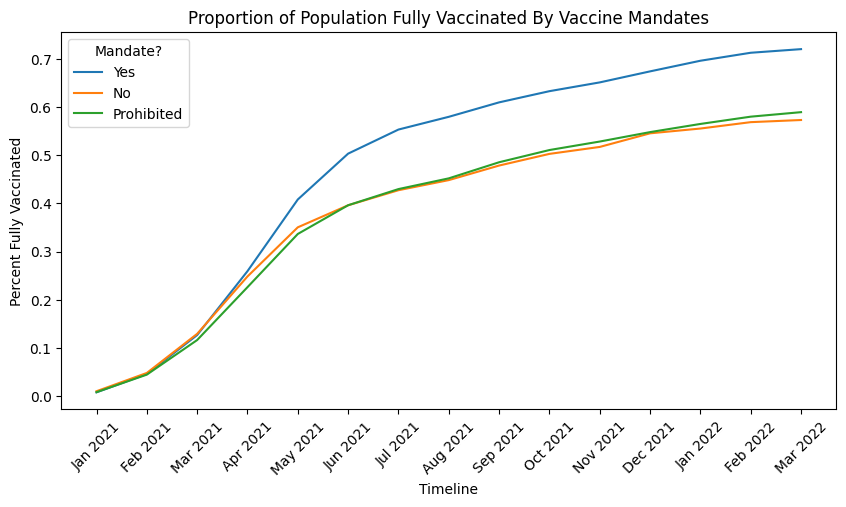

In [13]:
# JHU Vaccine Rates (based on Census 2019 Population) Plot

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.lineplot(
    data=vacc_all_jhu_pop,
    x="Time",
    y="People_Fully_Vaccinated",
    hue="Mandate?",
    ci=None,
)

ax.set(xlabel="Timeline", ylabel="Percent Fully Vaccinated")
ax.set(title="Proportion of Population Fully Vaccinated By Vaccine Mandates")
plt.xticks(rotation=45)

<AxesSubplot:xlabel='Date', ylabel='Administered_Dose1_Pop_Pct'>

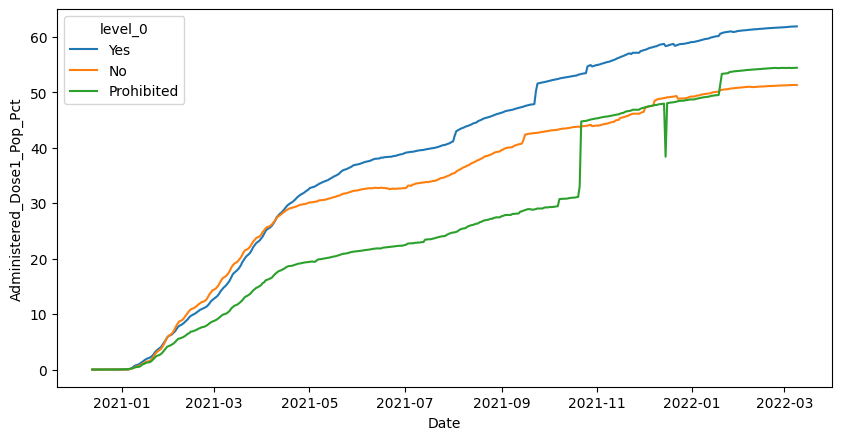

In [14]:
# CDC Vaccine Rates Plot
# Something really weird going on here, need to double check raw data to see what is happening

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.lineplot(
    data=vacc_all_cdc, x="Date", y="Administered_Dose1_Pop_Pct", hue="level_0", ci=None
)